In [ ]:
#| hide
!pip install diffusers
!pip install transformers
!pip install bitsandbytes
!pip install nbdev
!pip install accelerate

In [ ]:
#| export
from tqdm.auto import tqdm
from diffusers import AutoencoderKL,UNet2DConditionModel,LMSDiscreteScheduler
from transformers import CLIPTextModel, CLIPTokenizer
import torch,numpy as np
import torch.nn.functional as F,torch.nn as nn
from torchvision import transforms as tfms
from  PIL import Image
from dataclasses import dataclass
from torch.utils.data import dataset, sampler, dataloader
import gc,os
import bitsandbytes as bnb
from accelerate import Accelerator


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /Users/zhanggxk/project/anaconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so
CUDA SETUP: Loading binary /Users/zhanggxk/project/anaconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so...
dlopen(/Users/zhanggxk/project/anaconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so, 0x0006): tried: '/Users/zhanggxk/project/anaconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so' (not a mach-o file), '/System/Volumes/Preboot/Cryptexes/OS/Users/zhanggxk/project/anaconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so' (no such file), '/Users/zhanggxk/project/anaconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cp

/Users/zhanggxk/project/anaconda3/lib/python3.10/site-packages/bitsandbytes/cextension.py:33: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [ ]:
#| default_exp imageic_train

## 超参准备

In [ ]:
#| export
@dataclass
class HiperParam:
    prompt:str='A photo of Barack Obama smiling with a big grin.'
    #训练步数
    optimizer_training_loop:int=4
    unet_training_loop:int=3
    mix_precison:str='no'
    min_timestamps:int=200
    max_timestamps:int=500
    use_8bit_adam:bool=False

    lr:float=1e-6
    lr_emb:float=1e-3
    
    batch_size:int=1    
    accum_steps:int=1
    
 
    enable_gradient_checkpointing:bool=True
     
    
    output:str='weights'
    log_interval:int=1
    eval_interval:int=1000
    
hparam=HiperParam()

In [ ]:
os.makedirs(hparam.output,exist_ok=True)
hparam

HiperParam(prompt='A photo of Barack Obama smiling with a big grin.', optimizer_training_loop=4, unet_training_loop=3, mix_precison='no', min_timestamps=200, max_timestamps=500, use_8bit_adam=False, lr=1e-06, lr_emb=0.001, batch_size=1, accum_steps=1, enable_gradient_checkpointing=True, output='weights', log_interval=1, eval_interval=1000)

## 工具函数

In [ ]:
#| export
def release_cache():
    gc.collect()
    torch.cuda.empty_cache()
    print(torch.cuda.list_gpu_processes())
    
#把图片排成 rows,cols的网格中，先排cols,后排rows
#其中len(imgs)=cols x rows
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid
def isColab(versoze=False):
    try:
        import google.colab
        IN_COLAB = True
    except:
        IN_COLAB = False
    if versoze:
        if IN_COLAB:
            print("当前环境是Colab")
        else:
            print("当前环境不是Colab")
    return IN_COLAB
_=isColab(True)

当前环境不是Colab


## 模型准备

In [ ]:
#| export
modelName="CompVis/stable-diffusion-v1-4"

vae=AutoencoderKL.from_pretrained(modelName,subfolder='vae')
tokenizer=CLIPTokenizer.from_pretrained(modelName,subfolder="tokenizer")
text_encoder=CLIPTextModel.from_pretrained(modelName,subfolder="text_encoder")
unet=UNet2DConditionModel.from_pretrained(modelName,subfolder='unet')
schedular=LMSDiscreteScheduler(beta_schedule='scaled_linear',beta_start=0.00085, beta_end=0.012 )

release_cache()

pynvml module not found, please install pynvml


In [ ]:
#| export
@torch.no_grad()
def pil2Latents(input_image:Image)-> torch.FloatTensor:
    '''
    把图片转换成vae的输入，生成的tensor在cpu上
    对图片进行的缩放处理，短边变成512px，长边采用中心切割的方式。
    返回：size=[1,4,64,64]
    '''
    image_transforms = tfms.Compose(
        [
            tfms.Resize(512, interpolation=tfms.InterpolationMode.BILINEAR),
            tfms.CenterCrop(512),
            tfms.ToTensor(),
            tfms.Normalize([0.5], [0.5]),
        ]
    )
    
    ts=image_transforms(input_image).unsqueeze(0)
    return 0.18215*vae.encode(ts).latent_dist.sample()
@torch.no_grad()
def latents2Pil(latents:torch.FloatTensor) ->Image:
    '''
    把隐变量还原成PIL.Image
    latents: FloatTensor,size=[1,4,64,64]
    '''
    # [-1,1] 
    latent_transforms=tfms.Normalize([-1], [2])
    
    decode_img=vae.decode(latents/0.18215).sample.detach().cpu()
    decode_img=decode_img.permute(0,2,3,1).squeeze()
    decode_img=latent_transforms(decode_img).float().clamp(0,1)

    arr_img=decode_img.numpy()*255
    arr_img=arr_img.astype('uint8')
    return Image.fromarray(arr_img)

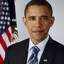

In [ ]:
img=Image.open('Obama.jpg')
lt=pil2Latents(img)
latents2Pil(lt).resize((64,64))

## 数据集准备

In [ ]:
#| export
class ImageDataSet(dataset.Dataset):
    def __init__(self,path) :
        self.data=pil2Latents(Image.open(path))
        self.ids=tokenizer(hparam.prompt,padding='max_length',truncation=True,max_length=tokenizer.model_max_length,return_tensors='pt').input_ids
    def __len__(self):
        return hparam.batch_size
    def __getitem__(self, index):
        
        noise=torch.rand_like(self.data) #这里需要to
        ts=torch.randint(hparam.min_timestamps,hparam.max_timestamps,(1,)) #这里需要to
        model_inp1=schedular.add_noise(self.data,noise,ts)

        return model_inp1[0],ts[0],self.ids[0],noise[0]
    

In [ ]:
!wget -O Obama.jpg "https://github.com/ShivamShrirao/diffusers/blob/main/examples/imagic/imgs/Official_portrait_of_Barack_Obama.jpg?raw=true"

In [ ]:
#| export
ds=ImageDataSet('Obama.jpg')
dls=dataloader.DataLoader(ds,hparam.batch_size,shuffle=False)
release_cache()

pynvml module not found, please install pynvml


探索不同的noise解析效果

In [ ]:
hparam.max_timestamps=500
hparam.min_timestamps=200
for lt,t,tx,noise in dls:
    print(lt.shape,tx.shape,t,noise.shape)

torch.Size([1, 4, 64, 64]) torch.Size([1, 77]) tensor([337]) torch.Size([1, 4, 64, 64])


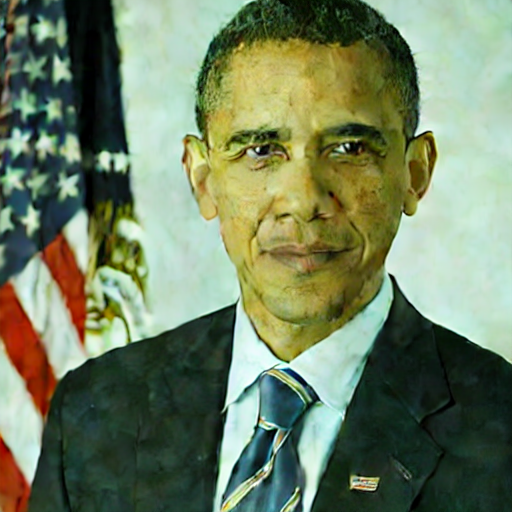

In [ ]:
# latents2Pil(lt)

In [ ]:
schedular.add_noise??

Signature:
schedular.add_noise(
    original_samples: torch.FloatTensor,
    noise: torch.FloatTensor,
    timesteps: torch.FloatTensor,
) -> torch.FloatTensor
Docstring: <no docstring>
Source:   
    def add_noise(
        self,
        original_samples: torch.FloatTensor,
        noise: torch.FloatTensor,
        timesteps: torch.FloatTensor,
    ) -> torch.FloatTensor:
        # Make sure sigmas and timesteps have the same device and dtype as original_samples
        sigmas = self.sigmas.to(device=original_samples.device, dtype=original_samples.dtype)
        if original_samples.device.type == "mps" and torch.is_floating_point(timesteps):
            # mps does not support float64
            schedule_timesteps = self.timesteps.to(original_samples.device, dtype=torch.float32)
            timesteps = timesteps.to(original_samples.device, dtype=torch.float32)
        else:
            schedule_timesteps = self.timesteps.to(original_samples.device)
            timesteps = timesteps.to(

In [ ]:
schedular.sigmas

tensor([14.6146, 14.5263, 14.4386,  ...,  0.0413,  0.0292,  0.0000])

## 训练代码

训练主流程

In [ ]:
#| export
def getUNetParams(unet):
    if isColab():
        return unet.parameters()
    else:
        return unet.conv_out.parameters() 

def freeze_weight(model):
    for p in model.parameters():
        p.requires_grad_(False)
def unFreeze_weight(model):
    params=model.parameters()
    if isinstance(model,UNet2DConditionModel):
        params=getUNetParams(model)
    for p in params:
        p.requires_grad_(True)
        
def train_func(hparam,dls,text_encoder,unet):
    accelertor=Accelerator(
        mixed_precision=hparam.mix_precison,
        gradient_accumulation_steps=hparam.accum_steps)
    #默认全部都不参与训练
    freeze_weight(unet)
    if hparam.enable_gradient_checkpointing:
        unet.enable_gradient_checkpointing()
    
    dls,unet,text_encoder=accelertor.prepare(dls,unet,text_encoder)
    
    
    def save_model(obj,name):
        if accelertor.is_main_process:
            torch.save(obj,f'{hparam.output}/{name}.pt')
            
    _,_,ids,_ =next(iter(dls))
    with torch.inference_mode():
        target_emb=text_encoder(ids).last_hidden_state
        save_model(target_emb,'target')
    optimized_emb=nn.Parameter(target_emb.clone())
    del text_encoder
    release_cache()
    
    
    
    def train_one_stage(pbar,optimizer,t_inp,bar_prmpt):
        pbar.set_description(bar_prmpt)
        for i in pbar:
            for model_inp1,t,ids,noise in dls:
                with accelertor.accumulate(unet):
                    noise_pred = unet(model_inp1, t, encoder_hidden_states=t_inp).sample
                    loss=F.mse_loss(noise_pred,noise)
                    accelertor.backward(loss)
                    optimizer.step()
                    optimizer.zero_grad()
                    pbar.update(1)

                    if i%hparam.log_interval==0:
                        pbar.set_postfix(Loss=f"{loss.cpu().item():.3f}")
    
    optimize_class=bnb.optim.Adam8bit if hparam.use_8bit_adam else torch.optim.Adam
    #第一阶段的训练,token_embedding.weights
    
    optimizer=accelertor.prepare(optimize_class([optimized_emb],hparam.lr_emb))
    pbar=tqdm(range(hparam.optimizer_training_loop),disable=not accelertor.is_main_process)
    
    train_one_stage(pbar,optimizer,optimized_emb,"step 1")
    
    with torch.inference_mode():
        save_model(optimized_emb,'optimizer')
    
    optimized_emb.requires_grad_(False)
    
    
    release_cache()
    #第二阶段的训练,unet.weights
    
    
    unFreeze_weight(unet)
    
    unet.train()
    pbar=tqdm(range(hparam.unet_training_loop),disable=not accelertor.is_main_process)
    optimizer=accelertor.prepare(torch.optim.Adam(getUNetParams(unet),hparam.lr))

    train_one_stage(pbar,optimizer,optimized_emb,"step 2")
    
    save_model(unet.state_dict(),'unet')
    

In [ ]:
#| export
if __name__ == '__main__':
    train_func(hparam,dls,text_encoder,unet)

pynvml module not found, please install pynvml


  0%|          | 0/4 [00:00<?, ?it/s]

pynvml module not found, please install pynvml


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
from nbdev import nbdev_export
nbdev_export('.')

In [ ]:
from accelerate import notebook_launcher

notebook_launcher(train_func,(hparam,dls,text_encoder,unet),num_processes=1,mixed_precision='fp16')

Launching training on MPS.
pynvml module not found, please install pynvml


  0%|          | 0/4 [00:00<?, ?it/s]

pynvml module not found, please install pynvml


  0%|          | 0/3 [00:00<?, ?it/s]

## 推理代码

In [ ]:
from diffusers import StableDiffusionPipeline

1.重新加载模型

In [ ]:
torch_device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
modelName="CompVis/stable-diffusion-v1-4"
vae=AutoencoderKL.from_pretrained(modelName,subfolder='vae')
tokenizer=CLIPTokenizer.from_pretrained(modelName,subfolder="tokenizer")
text_encoder=CLIPTextModel.from_pretrained(modelName,subfolder="text_encoder")
unet=UNet2DConditionModel.from_pretrained(modelName,subfolder='unet')
schedular=LMSDiscreteScheduler(beta_schedule='scaled_linear',beta_start=0.00085, beta_end=0.012 )


2.加载训练好的unet,target_emb,optimemb

In [ ]:
target_emb=torch.load(f'{hparam.output}/target.pt',map_location='cpu')
optimemb=torch.load(f'{hparam.output}/optimizer.pt',map_location='cpu')

#@markdown target emb的权重
alpha=0.5 #@param {type:"string"}
token_emb=alpha*target_emb+(1-alpha)*optimemb


unet_state=torch.load(f'{hparam.output}/unet.pt',map_location='cpu')
unet.load_state_dict(unet_state)

<All keys matched successfully>

In [ ]:
pipe=StableDiffusionPipeline(vae,text_encoder,tokenizer,unet,schedular,None,None).to(torch_device)

In [ ]:
torch.manual_seed(1)

prompt = "a photograph of an astronaut riding a horse"
image=pipe(prompt).images[0] #每个提示产生一张图片

image

pipe调用参数[参考文档](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/text2img#diffusers.StableDiffusionPipeline.__call__)

In [ ]:
img_latent=pil2Latents(Image.open('Obama.jpg'))

In [ ]:
g_cuda = torch.Generator(device=torch_device)
seed = 4324 #@param {type:"number"}
g_cuda.manual_seed(seed)
                   
with torch.inference_mode():
    images = pipe(
        prompt_embeds=token_emb,
        num_images_per_prompt=1,
        num_inference_steps=10,
        guidance_scale=7.5,
        generator=g_cuda,
        latents=img_latent
    ).images

  0%|          | 0/10 [00:00<?, ?it/s]

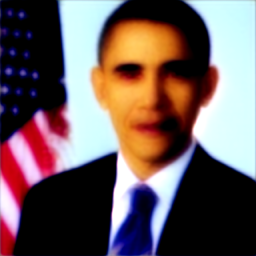

In [ ]:
image_grid(images,1,len(images)).resize((256*len(images),256))